# **Proyek Capstone bagian Klasifikasi Gambar: Garbage Dataset**

**Sumber Data**: [Garbage Dataset Drive](https://drive.google.com/drive/folders/1zPrwMudsN1noPgwqa6xHDSHPUkWeXWNK?usp=sharing)

## **Import Packages/Library**

In [ ]:
!pip install Pillow
!pip install tqdm
!pip install tensorflowjs
!pip install -q keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.7 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.34.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
db-dtypes 1.4.3 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [ ]:
import os
import time
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import zipfile
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm  #untuk progress bar
from sklearn.model_selection import train_test_split
import tensorflowjs as tfjs
import skimage
from skimage import io, img_as_ubyte
from skimage.transform import resize, rotate, AffineTransform, warp
from skimage.exposure import adjust_gamma
from skimage.util import random_noise
import keras
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import Model, models, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import TFSMLayer, InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
import glob
import tensorflowjs as tfjs
import pathlib
from tensorflow.keras.layers import Input
from sklearn.metrics import accuracy_score
import zipfile
from google.colab import files
from google.colab import drive
from PIL import Image, ImageDraw, ImageFont
from tensorflow import lite


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) #mengabaikan peringatan

In [ ]:
# Mencetak versi TensorFlow yang sedang digunakan
print(tf.__version__)

2.18.0


## **Data Preparation**

### **Data Loading**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
folder_path = '/content/drive/My Drive/Capstone/Garbage-Dataset-EcoSortify'

In [ ]:
# Menampilkan isi folder
print(os.listdir(folder_path))

['Anorganik', 'Elektronik', 'Organik', 'Residu & B3']


In [ ]:
# Mendapatkan daftar kategori di dalam folder garbage-dataset
categories = os.listdir(folder_path)

# Dictionary untuk menyimpan jumlah gambar per kategori
image_counts = {}

# Ekstensi file gambar yang umum
image_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.gif', '.webp')

print("🔎 Menghitung jumlah gambar per kategori...\n")

# Loop dengan progress bar
for category in tqdm(categories, desc="⏳ Proses kategori"):
    category_path = os.path.join(folder_path, category)
    total_images = 0

    # Telusuri seluruh subfolder dalam kategori
    for root, dirs, files in os.walk(category_path):
        total_images += len([f for f in files if f.lower().endswith(image_extensions)])

    image_counts[category] = total_images

# Cetak hasil
print("\n📊 Jumlah gambar di setiap kategori:")
for category in categories:
    print(f"{category}: {image_counts[category]} gambar")

🔎 Menghitung jumlah gambar per kategori...



⏳ Proses kategori: 100%|██████████| 4/4 [01:29<00:00, 22.43s/it]


📊 Jumlah gambar di setiap kategori:
Anorganik: 17237 gambar
Elektronik: 11326 gambar
Organik: 15530 gambar
Residu & B3: 6744 gambar


In [ ]:
# Path utama
path_utama = '/content/sample_data/path_utama'

# Path subfolder
untouched_path = os.path.join(path_utama, 'untouched')
sampled_path = os.path.join(path_utama, 'sampled')
augmented_path = os.path.join(path_utama, 'augmented')

# Membuat direktori struktur folder (tanpa menghapus jika sudah ada)
os.makedirs(untouched_path, exist_ok=True)
os.makedirs(sampled_path, exist_ok=True)
os.makedirs(augmented_path, exist_ok=True)

# 1. Salin semua gambar dari dataset asli ke folder 'untouched'
print("\n📁 Menyalin gambar ke folder 'untouched'...\n")
for category in tqdm(categories, desc="Salin kategori"):
    src_category_path = os.path.join(folder_path, category)
    dst_category_path = os.path.join(untouched_path, category)
    os.makedirs(dst_category_path, exist_ok=True)

    for root, _, files in os.walk(src_category_path):
        for file in files:
            if file.lower().endswith(image_extensions):
                src_file = os.path.join(root, file)
                dst_file = os.path.join(dst_category_path, f"{os.path.basename(root)}_{file}")
                shutil.copy2(src_file, dst_file)

# 2. Hitung jumlah gambar per label di 'untouched'
print("\n📂 Jumlah gambar per label dalam 'untouched':")
untouched_counts = {}
for category in categories:
    label_path = os.path.join(untouched_path, category)
    total = len([f for f in os.listdir(label_path) if f.lower().endswith(image_extensions)])
    untouched_counts[category] = total
    print(f"{category}: {total} gambar")

# 3. Sampling 5000 gambar per label ke folder 'sampled'
print("\n🔁 Sampling 5000 gambar per label ke 'sampled'...\n")

sampled_counts = {}
for category in tqdm(categories, desc="Sampling kategori"):
    src_label_path = os.path.join(untouched_path, category)
    dst_label_path = os.path.join(sampled_path, category)
    os.makedirs(dst_label_path, exist_ok=True)

    all_images = [f for f in os.listdir(src_label_path) if f.lower().endswith(image_extensions)]

    if len(all_images) >= 5000:
        sampled_images = random.sample(all_images, 5000)
    else:
        print(f"⚠️  WARNING: Gambar '{category}' hanya {len(all_images)}. Sampling dengan pengulangan untuk mencapai 5.000.")
        sampled_images = list(np.random.choice(all_images, size=5000, replace=True))

    for i, fname in enumerate(tqdm(sampled_images, desc=f"Salin {category}", leave=False)):
        src_file = os.path.join(src_label_path, fname)
        new_name = f"{i}_{fname}" if sampled_images.count(fname) > 1 else fname
        shutil.copy2(src_file, os.path.join(dst_label_path, new_name))


📁 Menyalin gambar ke folder 'untouched'...



Salin kategori: 100%|██████████| 4/4 [19:47<00:00, 296.89s/it]



📂 Jumlah gambar per label dalam 'untouched':
Anorganik: 17119 gambar
Elektronik: 11326 gambar
Organik: 15530 gambar
Residu & B3: 6744 gambar

🔁 Sampling 5000 gambar per label ke 'sampled'...



Sampling kategori: 100%|██████████| 4/4 [00:31<00:00,  7.78s/it]


### **Grafik Penyebaran Data**

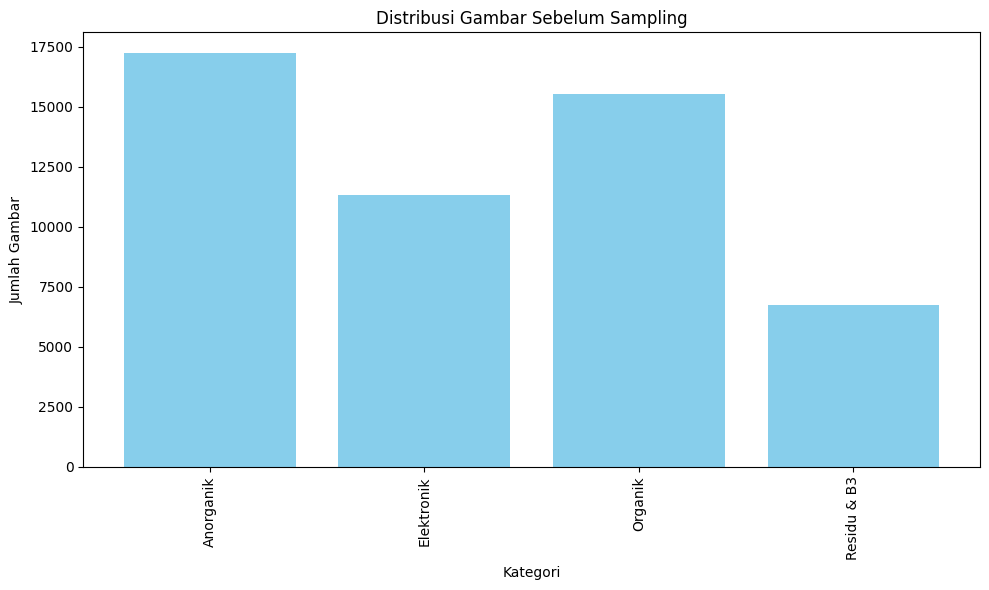

In [ ]:
# Membuat grafik distribusi label sebelum sampling
plt.figure(figsize=(10, 6))
plt.bar(image_counts.keys(), image_counts.values(), color='skyblue')
plt.xlabel('Kategori')
plt.ylabel('Jumlah Gambar')
plt.title('Distribusi Gambar Sebelum Sampling')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### **Cek Resolusi Gambar**

In [ ]:
# Fungsi untuk mendapatkan resolusi gambar
def get_image_resolution(image_path):
    with Image.open(image_path) as img:
        return img.size  # Mengembalikan (width, height)

# Memilih dan menampilkan gambar acak beserta resolusinya dari setiap kategori
print("\n Resolusi gambar acak dari setiap kategori:\n")

for category in categories:
    category_path = os.path.join(untouched_path, category)
    all_images = [f for f in os.listdir(category_path) if f.lower().endswith(image_extensions)]

    # Pilih 3 gambar acak untuk ditampilkan resolusinya
    random_images = random.sample(all_images, min(3, len(all_images)))

    print(f"\nResolusi gambar acak dari label '{category}':")
    for image in random_images:
        image_path = os.path.join(category_path, image)
        resolution = get_image_resolution(image_path)
        print(f"Nama Gambar: {image}, Resolusi: {resolution[0]}x{resolution[1]}")


 Resolusi gambar acak dari setiap kategori:


Resolusi gambar acak dari label 'Anorganik':
Nama Gambar: plastic_plastic_345.jpg, Resolusi: 275x183
Nama Gambar: cardboard_cardboard_522.jpg, Resolusi: 474x586
Nama Gambar: glass_glass_2625.jpg, Resolusi: 214x235

Resolusi gambar acak dari label 'Elektronik':
Nama Gambar: Mobile_Mobile_52.jpg, Resolusi: 150x150
Nama Gambar: electrowaste_IMG_20190212_214607_jpg.rf.bef7e603b85afa1b74d300f496561f34.jpg, Resolusi: 224x224
Nama Gambar: electrowaste_IMG_20190212_214259_jpg.rf.3fc11429971577d7e3dd42245e3dded0.jpg, Resolusi: 224x224

Resolusi gambar acak dari label 'Organik':
Nama Gambar: organik_busuk_organic_006078_photo.jpg, Resolusi: 225x225
Nama Gambar: organik_busuk_organic_007212_photo.jpg, Resolusi: 284x177
Nama Gambar: organik_busuk_organic_000158_photo.jpg, Resolusi: 275x183

Resolusi gambar acak dari label 'Residu & B3':
Nama Gambar: Residu_Residu (1308).jpg, Resolusi: 1836x2615
Nama Gambar: trash_trash_20240626_154756.jpg, Resolusi: 8

Terbukti bahwa resolusi dataset awal memang beragam tanpa preprocessing.

### **Sample gambar untuk semua kelas**

Menampilkan gambar acak dari kategori: Anorganik


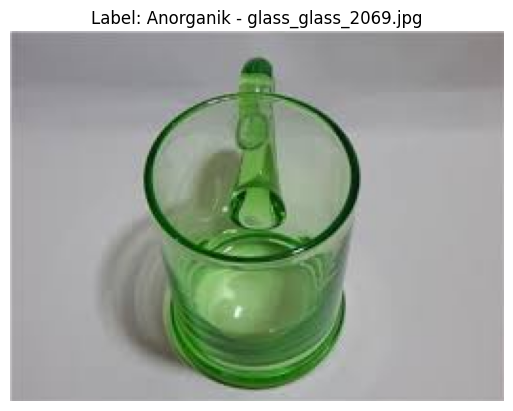

Menampilkan gambar acak dari kategori: Elektronik


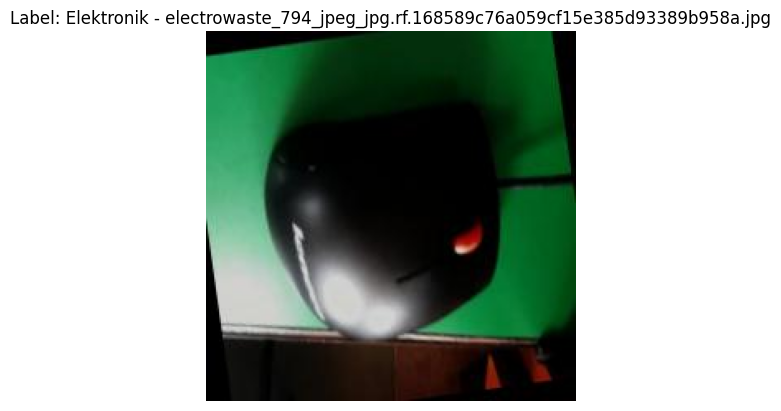

Menampilkan gambar acak dari kategori: Organik


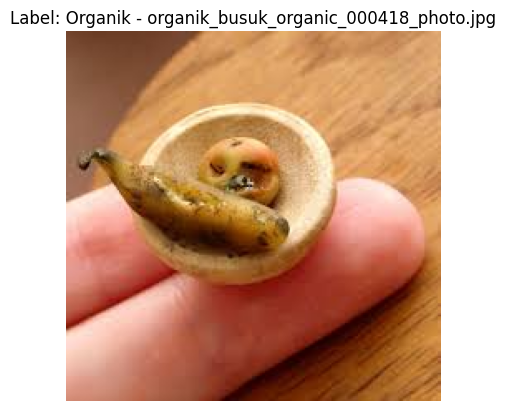

Menampilkan gambar acak dari kategori: Residu & B3


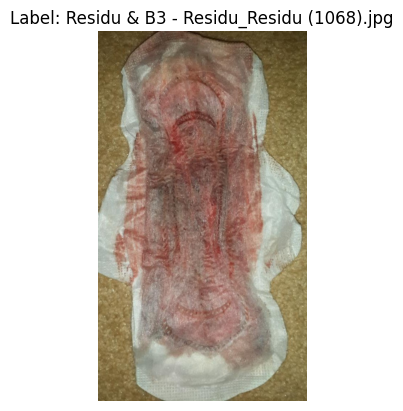

In [ ]:
# Fungsi untuk menampilkan gambar acak dari setiap kategori
def show_random_image_from_category(category_path, category):
    # Ambil semua gambar dari kategori
    all_images = [f for f in os.listdir(category_path) if f.lower().endswith(image_extensions)]

    # Pilih satu gambar acak dari kategori
    random_image = random.choice(all_images)
    image_path = os.path.join(category_path, random_image)

    # Buka gambar menggunakan PIL dan tampilkan menggunakan matplotlib
    with Image.open(image_path) as img:
        plt.imshow(img)
        plt.axis('off')  # Matikan axis untuk menampilkan gambar tanpa sumbu
        plt.title(f"Label: {category} - {random_image}")  # Judul gambar
        plt.show()

# Menampilkan 1 gambar acak dari setiap kategori
for category in categories:
    category_path = os.path.join(untouched_path, category)
    print(f"Menampilkan gambar acak dari kategori: {category}")
    show_random_image_from_category(category_path, category)

## **Data Preprocessing**

### **Data Augmentation**



Beberapa strategi augmentasi gambar yang saya terapkan:

- `anticlockwise_rotation` adalah ketika gambar diputar ke arah berlawanan dengan arah jarum jam.
- `clockwise_rotation` adalah ketika gambar diputar ke arah searah dengan arah jarum jam.
- `flip_up_down` adalah ketika gambar dibalik secara vertikal dari atas ke bawah.
- `sheared` adalah ketika gambar diberikan efek pergeseran acak.
- `blur` adalah ketika gambar diberikan efek kabur atau blur.
- `wrap_shift` adalah ketika gambar diberikan efek pergeseran melengkung.
- `brightness` adalah ketika gambar diberikan efek peningkatan kecerahan.

In [ ]:
# Fungsi augmentasi yang telah kamu tentukan
def anticlockwise_rotation(img):
    img = tf.image.resize(img, (224, 224))
    img = tf.image.rot90(img, k=random.randint(1, 4))
    return img

def flip_up_down(img):
    img = tf.image.resize(img, (224, 224))
    img = tf.image.flip_up_down(img)
    return img

def add_brightness(img):
    img = tf.image.resize(img, (224, 224))
    img = tf.image.adjust_brightness(img, delta=random.uniform(0.1, 0.5))
    return img

def blur_image(img):
    img = tf.image.resize(img, (224, 224))
    img = tf.keras.layers.GaussianNoise(stddev=random.uniform(0.01, 0.05))(img)
    return img

def sheared(img):
    img = tf.image.resize(img, (224, 224))
    datagen = ImageDataGenerator(shear_range=0.2)
    img = next(iter(datagen.flow(tf.expand_dims(img, 0))))[0]
    return img

def warp_shift(img):
    img = tf.image.resize(img, (224, 224))
    datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1)
    img = next(iter(datagen.flow(tf.expand_dims(img, 0))))[0]
    return img

# Daftar fungsi augmentasi
augment_funcs = [
    anticlockwise_rotation,
    flip_up_down,
    add_brightness,
    blur_image,
    sheared,
    warp_shift
]

In [ ]:
# Fungsi untuk memastikan gambar dalam format uint8 sebelum disimpan
def normalize_image(img):
    img = tf.clip_by_value(img, 0.0, 255.0)  # Memastikan nilai dalam rentang 0-255
    img = tf.cast(img, tf.uint8)  # Mengubah tipe tensor menjadi uint8
    return img

# Fungsi untuk memeriksa apakah file adalah gambar yang valid
def is_valid_image(image_path):
    try:
        img = tf.io.read_file(image_path)
        img = tf.image.decode_jpeg(img, channels=3)  # Mencoba decode sebagai JPEG
        return True
    except (tf.errors.InvalidArgumentError, ValueError):
        return False
# Augmentasi dan simpan hasilnya dengan progress bar
def augment_and_save_images():
    print("🔄 Proses augmentasi gambar dimulai...\n")

    for category in categories:
        category_path = os.path.join(sampled_path, category)
        augmented_category_path = os.path.join(augmented_path, category)
        os.makedirs(augmented_category_path, exist_ok=True)

        # Ambil semua gambar dalam kategori
        all_images = [f for f in os.listdir(category_path) if f.lower().endswith(image_extensions)]

        # Batasi jumlah gambar yang akan diaugmentasi menjadi 100 per kategori
        num_images_to_augment = min(100, len(all_images))

        # Proses gambar dengan progress bar untuk setiap kategori
        with tqdm(total=num_images_to_augment, desc=f"Augmentasi {category}", unit="gambar") as pbar:
            for i, image in enumerate(all_images[:num_images_to_augment]):
                image_path = os.path.join(category_path, image)

                # Pastikan file gambar valid sebelum diproses
                if not is_valid_image(image_path):
                    print(f"❌ File tidak valid atau format tidak didukung: {image} di folder '{category}'")
                    continue

                # Baca gambar
                img = tf.io.read_file(image_path)
                img = tf.image.decode_jpeg(img, channels=3)  # Decode gambar JPG ke tensor

                # Terapkan augmentasi secara acak
                augment_func = random.choice(augment_funcs)
                augmented_img = augment_func(img)

                # Pastikan gambar berada dalam format uint8 sebelum disimpan
                augmented_img = normalize_image(augmented_img)

                # Simpan gambar yang sudah diaugmentasi
                augmented_image_path = os.path.join(augmented_category_path, f"aug_{image}")
                augmented_img = tf.image.encode_jpeg(augmented_img)  # Encode gambar kembali ke format jpeg
                tf.io.write_file(augmented_image_path, augmented_img)

                # Update progress bar setelah setiap gambar
                pbar.update(1)

    print("\n✅ Augmentasi gambar selesai. Semua hasil disimpan sesuai labelnya.")

# Panggil fungsi augmentasi dan simpan gambar
augment_and_save_images()

🔄 Proses augmentasi gambar dimulai...



Augmentasi Residu & B3: 100%|██████████| 100/100 [00:02<00:00, 45.67gambar/s]


✅ Augmentasi gambar selesai. Semua hasil disimpan sesuai labelnya.


In [ ]:
# Fungsi untuk mengecek format gambar
def check_image_format(image_path):
    try:
        with Image.open(image_path) as img:
            img.verify()  # Mengecek integritas gambar
            img.close()  # Pastikan gambar ditutup setelah pengecekan
            return True
    except (IOError, SyntaxError):
        return False

# Path direktori gambar hasil augmentasi
augmented_dir = '/content/sample_data/path_utama/augmented'

# Label yang digunakan dalam dataset adalah
labels = ['Anorganik', 'Elektronik', 'Organik', 'Residu & B3']

# Menelusuri setiap folder label untuk mengecek gambar yang tidak valid
for label in labels:
    label_folder = os.path.join(augmented_dir, label)

    if not os.path.exists(label_folder):
        print(f"Folder {label_folder} tidak ditemukan.")
        continue

    images = os.listdir(label_folder)

    # Iterasi untuk mengecek setiap gambar dalam folder
    for img_name in images:
        img_path = os.path.join(label_folder, img_name)
        if not check_image_format(img_path):
            print(f"❌ Gambar tidak valid atau format tidak didukung: {img_name} di folder '{label}'")

Karena tidak ada output yang mengatakan invalid format, maka semuanya valid.

In [ ]:
# Fungsi untuk mengecek apakah dimensi gambar valid
def check_image_dimensions(image_path):
    try:
        img_raw = tf.io.read_file(image_path)  # Membaca file gambar
        img_tensor = tf.image.decode_image(img_raw, channels=3)  # Dekode gambar sebagai RGB
        img_shape = tf.shape(img_tensor)  # Ambil dimensi gambar

        # Cek apakah tinggi dan lebar > 0
        return img_shape[0] > 0 and img_shape[1] > 0
    except Exception:
        # Jika ada error saat membaca atau decoding gambar
        return False

# Path folder augmented
augmented_dir = '/content/sample_data/path_utama/augmented'

# Label dataset
labels = ['Anorganik', 'Elektronik', 'Organik', 'Residu & B3']


# Loop untuk mengecek tiap gambar
for label in labels:
    label_folder = os.path.join(augmented_dir, label)

    if not os.path.exists(label_folder):
        print(f"[WARNING] Folder '{label_folder}' tidak ditemukan.")
        continue

    image_files = os.listdir(label_folder)

    for img_name in image_files:
        img_path = os.path.join(label_folder, img_name)

        # Lewati jika bukan file atau bukan file gambar
        if not os.path.isfile(img_path) or not img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue

        if not check_image_dimensions(img_path):
            print(f"[INVALID ❌] Dimensi rusak atau tidak terbaca - {img_name} di folder '{label}'")

Karena tidak ada output yang mengatakan invalid dimensions, maka semuanya valid.

### **Split Dataset**

In [ ]:
# Path direktori augmented dan sampled
augmented_dir = '/content/sample_data/path_utama/augmented'
sampled_dir = '/content/sample_data/path_utama/sampled'

# Menggabungkan gambar dari direktori 'augmented' dan 'sampled' dalam satu list
all_images = []

# Menggabungkan gambar dari augmented
for label in labels:
    label_augmented_dir = os.path.join(augmented_dir, label)
    # Tambahkan pengecekan apakah direktori augmented ada sebelum mencoba melisting isinya
    if os.path.exists(label_augmented_dir):
        all_images += [(os.path.join(label_augmented_dir, img), label) for img in os.listdir(label_augmented_dir)]
    else:
        print(f"WARNING: Direktori augmented untuk label '{label}' tidak ditemukan: {label_augmented_dir}")


# Menggabungkan gambar dari sampled
for label in labels:
    # Perbaiki path direktori sampled dengan menghapus '_sampled'
    label_sampled_dir = os.path.join(sampled_dir, label)
    # Tambahkan pengecekan apakah direktori sampled ada sebelum mencoba melisting isinya
    if os.path.exists(label_sampled_dir):
         all_images += [(os.path.join(label_sampled_dir, img), label) for img in os.listdir(label_sampled_dir)]
    else:
        print(f"WARNING: Direktori sampled untuk label '{label}' tidak ditemukan: {label_sampled_dir}")


# Menghitung jumlah gambar per label
category_counts_all = {label: 0 for label in labels}
for _, label in all_images:
    # Pastikan label ada dalam dictionary before incrementing
    if label in category_counts_all:
        category_counts_all[label] += 1
    else:
        # Handle cases where a label might be encountered that wasn't in the initial 'labels' list
        category_counts_all[label] = 1


print("Jumlah gambar dalam all_images:")
for label, count in category_counts_all.items():
    print(f"{label}: {count} gambar")

Jumlah gambar dalam all_images:
Anorganik: 5100 gambar
Elektronik: 5100 gambar
Organik: 5100 gambar
Residu & B3: 5100 gambar


In [ ]:
# Path untuk train, validation, dan test set
train_dir = '/content/sample_data/path_utama/train'
val_dir = '/content/sample_data/path_utama/val'
test_dir = '/content/sample_data/path_utama/test'

# Membuat folder jika belum ada
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Membuat subfolder untuk setiap label dalam train, val, test set
for label in labels:
    os.makedirs(os.path.join(train_dir, label), exist_ok=True)
    os.makedirs(os.path.join(val_dir, label), exist_ok=True)
    os.makedirs(os.path.join(test_dir, label), exist_ok=True)

In [ ]:
# Mengacak urutan gambar di all_images
random.shuffle(all_images)

# Menghitung jumlah total gambar
total_images = len(all_images)

# Menghitung jumlah gambar per set
train_size = int(0.7 * total_images)
val_size = int(0.15 * total_images)
test_size = total_images - train_size - val_size

# Membagi dataset menjadi training, validation, dan testing set
train_images = all_images[:train_size]
val_images = all_images[train_size:train_size + val_size]
test_images = all_images[train_size + val_size:]

# Fungsi untuk memindahkan gambar ke direktori yang sesuai
def move_images(image_list, destination_dir):
    for img_path, label in image_list:
        label_dir = os.path.join(destination_dir, label)
        shutil.copy(img_path, label_dir)

# Memindahkan gambar ke direktori train, val, test set
move_images(train_images, train_dir)
move_images(val_images, val_dir)
move_images(test_images, test_dir)

# Menghitung jumlah gambar per set (train, validation, test)
def count_images_in_dir(directory):
    count = {}
    for label in labels:
        label_dir = os.path.join(directory, label)
        count[label] = len(os.listdir(label_dir))
    return count

# Menghitung jumlah gambar di setiap set
train_counts = count_images_in_dir(train_dir)
val_counts = count_images_in_dir(val_dir)
test_counts = count_images_in_dir(test_dir)

# Menampilkan jumlah gambar di setiap set
print("\nJumlah gambar dalam training set:")
for label, count in train_counts.items():
    print(f"{label}: {count} gambar")

print("\nJumlah gambar dalam validation set:")
for label, count in val_counts.items():
    print(f"{label}: {count} gambar")

print("\nJumlah gambar dalam test set:")
for label, count in test_counts.items():
    print(f"{label}: {count} gambar")


Jumlah gambar dalam training set:
Anorganik: 3571 gambar
Elektronik: 3559 gambar
Organik: 3592 gambar
Residu & B3: 3558 gambar

Jumlah gambar dalam validation set:
Anorganik: 767 gambar
Elektronik: 791 gambar
Organik: 747 gambar
Residu & B3: 755 gambar

Jumlah gambar dalam test set:
Anorganik: 762 gambar
Elektronik: 750 gambar
Organik: 761 gambar
Residu & B3: 787 gambar


### **Image Data Generator**



In TensorFlow you can do this through the `tf.keras.preprocessing.image.ImageDataGenerator` class. This class allows you to do:
- Configure the random transformation and normalization operations to be performed on the image data during training
- Instantiate generator of augmented image sets (and their labels) via `.flow(data, labels)` or `.flow_from_directory(directory)`. This generator can then be used with `tf.keras` model methods which accept generator data as input, `fit`, `evaluate` and `predict`

Prepare the training and validation data, to begin with using `.flow_from_directory()` which generates image datasets and their labels directly in their respective folders by setting the `WIDTH` and `HEIGHT` size, predefined `BATCH SIZE` size and mode its class. Here we use `"binary"` class mode because the number of classes used is 2.

In [ ]:
BATCH_SIZE = 32
TARGET_SIZE = (250, 250)

# Inisialisasi ImageDataGenerator dengan augmentasi dan normalisasi
train_datagen = ImageDataGenerator(
    rescale=1.0/255,  # Normalisasi gambar
    rotation_range=20,  # Rotasi gambar
    width_shift_range=0.2,  # Geser lebar gambar
    height_shift_range=0.2,  # Geser tinggi gambar
    vertical_flip=True,  # Flip vertikal
    fill_mode='nearest',  # Isi pixel yang hilang
)

# Untuk data uji (test), hanya normalisasi tanpa augmentasi
test_datagen = ImageDataGenerator(rescale=1.0/255)  # Normalisasi untuk test set

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size= TARGET_SIZE,  # Ukuran input model sesuai konfigurasi
    batch_size= BATCH_SIZE,  # Batch size sesuai konfigurasi
    class_mode='categorical'
)

validation_generator = test_datagen.flow_from_directory(
    val_dir,
    target_size= TARGET_SIZE,  # Ukuran input model sesuai konfigurasi
    batch_size= BATCH_SIZE,  # Batch size sesuai konfigurasi
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size= TARGET_SIZE,  # Ukuran input model sesuai konfigurasi
    batch_size= BATCH_SIZE,  # Batch size sesuai konfigurasi
    class_mode='categorical'
)

Found 14271 images belonging to 4 classes.
Found 3058 images belonging to 4 classes.
Found 3059 images belonging to 4 classes.


## **Modelling**

In [ ]:
# Fungsi untuk menghitung class weights
def compute_class_weights(train_path):
    # Mengambil semua file gambar dalam train set
    files = [i for i in glob.glob(train_path + "//*//*")]
    labels = [os.path.dirname(i).split("/")[-1] for i in files]  # Menyusun label dari nama folder
    class_labels = sorted(set(labels))  # Mengurutkan label
    # Menghitung class weight dengan 'balanced' untuk menangani ketidakseimbangan kelas
    class_weights = compute_class_weight(class_weight='balanced', classes=np.array(class_labels), y=labels)
    return dict(zip(class_labels, class_weights))

# Mendapatkan class weights untuk dataset training
train_dir = '/content/sample_data/path_utama/train'
class_weight_dict = compute_class_weights(train_dir)
print(class_weight_dict)

# Callback untuk menghentikan training jika akurasi sudah lebih dari 85%
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        val_accuracy = logs.get('val_accuracy')
        accuracy = logs.get('accuracy')
        if val_accuracy is not None and accuracy is not None:
            if val_accuracy > 0.85 and accuracy > 0.85:  # Akurasi lebih besar dari 85%
                print("\nAkurasi dan validasi akurasi sudah > 85%, training dihentikan.")
                self.model.stop_training = True
            else:
                print("\nBelum mencapai akurasi > 85%, lanjutkan training.")
        else:
            print("\nNilai akurasi tidak tersedia. Lanjutkan training.")

callbacks = myCallback()

# Menggunakan callback lainnya
callbacks_list = [
    EarlyStopping(monitor='val_accuracy', patience=5, verbose=2, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=3, verbose=2, min_lr=1e-6),
    callbacks  # Callback custom untuk menghentikan training saat akurasi > 85%
]

# Membuat base model dengan Xception (menggunakan input shape sesuai dengan dataset)
base_model = tf.keras.applications.Xception(input_shape=(250, 250, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze base model untuk fine-tuning

# Menentukan class names
class_names = labels

# Membuat model lengkap
model = models.Sequential()
model.add(base_model)
model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(len(class_names), activation='softmax'))  # Output layer dengan jumlah kelas sesuai

# Menyusun model
model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Menampilkan summary model
model.summary()

{'Anorganik': np.float64(0.9997199663959675), 'Elektronik': np.float64(1.0030907558302895), 'Organik': np.float64(0.9938752783964365), 'Residu & B3': np.float64(1.0033726812816188)}
83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 8, 8, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 512)      │     9,437,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,498,092 (131.60 MB)

 Trainable params: 13,635,588 (52.02 MB)

 Non-trainable params: 20,862,504 (79.58 MB)

In [ ]:
# Menghitung waktu mulai
start_time = time.time()

# Melatih model dengan data
history = model.fit(
    train_generator,  # Menggunakan generator training
    epochs=10,  # Menentukan jumlah epoch
    validation_data=validation_generator,  # Menggunakan validation generator
    class_weight=class_weight_dict,  # Menggunakan class weights untuk penyesuaian bobot kelas
    callbacks=callbacks_list  # Callback untuk penghentian lebih awal dan pengaturan lainnya
)

# Menghitung waktu selesai
end_time = time.time()
duration = end_time - start_time

# Menampilkan waktu training dalam format detik, menit, dan jam
print(f"Training time: {duration} seconds")
print(f"Training time: {duration / 60} minutes")
print(f"Training time: {duration / 3600} hours")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/10
219/446 ━━━━━━━━━━━━━━━━━━━━ 50:03 13s/step - accuracy: 0.6559 - loss: 1.7063

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


446/446 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.7023 - loss: 1.2780 
Belum mencapai akurasi > 85%, lanjutkan training.
446/446 ━━━━━━━━━━━━━━━━━━━━ 6877s 15s/step - accuracy: 0.7025 - loss: 1.2769 - val_accuracy: 0.8283 - val_loss: 0.4239 - learning_rate: 0.0010
Epoch 2/10
446/446 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.8267 - loss: 0.4685 
Belum mencapai akurasi > 85%, lanjutkan training.
446/446 ━━━━━━━━━━━━━━━━━━━━ 6870s 15s/step - accuracy: 0.8267 - loss: 0.4685 - val_accuracy: 0.8646 - val_loss: 0.3698 - learning_rate: 0.0010
Epoch 3/10
446/446 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.8429 - loss: 0.4364 
Belum mencapai akurasi > 85%, lanjutkan training.
446/446 ━━━━━━━━━━━━━━━━━━━━ 6828s 15s/step - accuracy: 0.8429 - loss: 0.4364 - val_accuracy: 0.8718 - val_loss: 0.3295 - learning_rate: 0.0010
Epoch 4/10
446/446 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.8586 - loss: 0.3873 
Akurasi dan validasi akurasi sudah > 85%, training dihentikan.
446/446 ━━━━━━━━━━

## **Evaluasi dan Visualisasi**

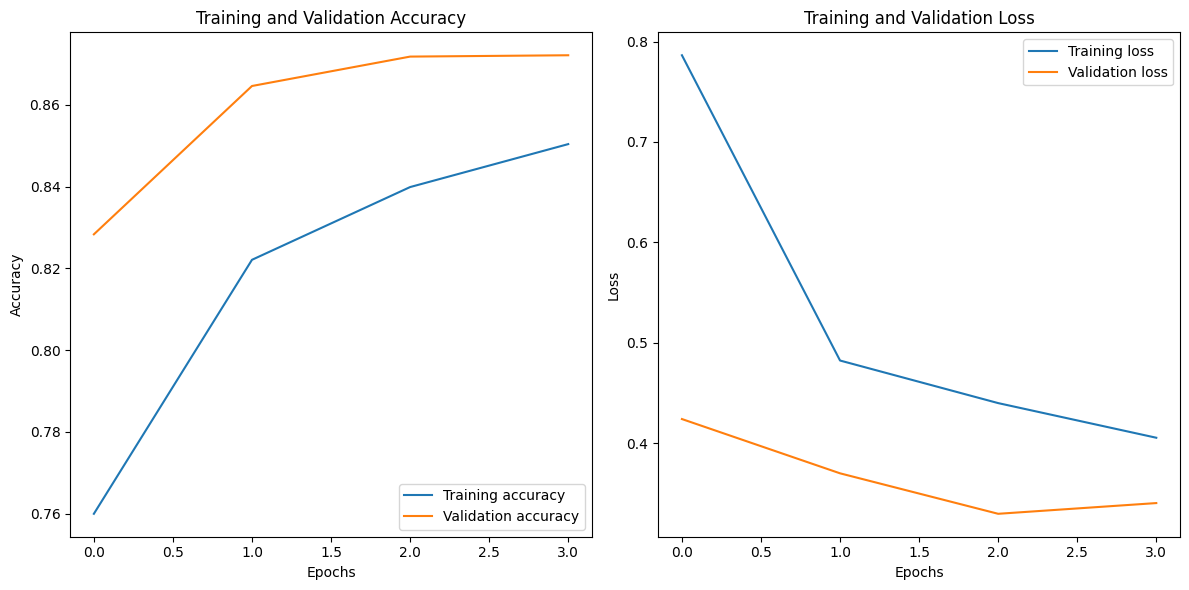

In [ ]:
# Mengambil data akurasi dan loss dari hasil pelatihan
history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

# Plot Akurasi
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training accuracy')
plt.plot(val_acc, label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Evaluasi Model untuk Training Dataset
score_train, acc_train = model.evaluate(train_generator)
print(f'Train Loss = {score_train}')
print(f'Train Accuracy = {acc_train}')

# Evaluasi Model untuk Validation Dataset
score_val, acc_val = model.evaluate(validation_generator)
print(f'Validation Loss = {score_val}')
print(f'Validation Accuracy = {acc_val}')

# Evaluasi Model untuk Test Dataset
score_test, acc_test = model.evaluate(test_generator)
print(f'Test Loss = {score_test}')
print(f'Test Accuracy = {acc_test}')

446/446 ━━━━━━━━━━━━━━━━━━━━ 4930s 11s/step - accuracy: 0.8707 - loss: 0.3182
Train Loss = 0.32651230692863464
Train Accuracy = 0.8692453503608704
96/96 ━━━━━━━━━━━━━━━━━━━━ 1008s 11s/step - accuracy: 0.8726 - loss: 0.3518
Validation Loss = 0.34015434980392456
Validation Accuracy = 0.8721386790275574
96/96 ━━━━━━━━━━━━━━━━━━━━ 1024s 11s/step - accuracy: 0.8662 - loss: 0.3334
Test Loss = 0.3589012920856476
Test Accuracy = 0.8617194890975952


## **Konversi Model**

In [ ]:
# Format SavedModel
saved_model_path = '/content/sample_data/path_utama/saved_model/'
# Membuat folder jika belum ada
os.makedirs(saved_model_path, exist_ok=True)

# Menyimpan model dalam Format SavedModel
tf.saved_model.save(model, saved_model_path)

# Menyimpan model dalam Format tfjs
!tensorflowjs_converter \
    --input_format=tf_saved_model \
    /content/sample_data/path_utama/saved_model/ \
    /content/sample_data/path_utama/modeltfjs

# Menyimpan model dalam Format TFLite
# Konversi ke TensorFlow Lite
tflite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = tflite_converter.convert()

# Membuat folder tflite jika belum ada
tflite_directory = '/content/sample_data/path_utama/tflite'
if not os.path.exists(tflite_directory):
    os.makedirs(tflite_directory)

# Menyimpan model TFLite di folder tflite
tflite_output_path = os.path.join(tflite_directory, 'model.tflite')
with open(tflite_output_path, "wb") as f:
    f.write(tflite_model)

# Fungsi untuk menghasilkan labels.txt
def recreate_labels(dataset_directory, output_file):
    # Ambil nama folder yang ada dalam direktori dataset
    labels = [folder for folder in os.listdir(dataset_directory) if not folder.startswith('.')]

    # Tulis nama kelas ke dalam file labels.txt
    with open(output_file, 'w') as file:
        for label in labels:
            file.write(label + '\n')  # Memastikan setiap label dipisah dengan newline

# Panggil fungsi untuk membuat file labels.txt
recreate_labels(dataset_directory=train_dir, output_file=os.path.join(tflite_directory, 'labels.txt'))

print("Konversi TFLite dan pembuatan labels.txt berhasil.")

2025-06-08 11:20:31.134412: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749381631.508834  175118 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749381631.622659  175118 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2025-06-08 11:20:51.551942: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
I0000 00:00:1749381656.747878  175118 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
I0000 00:00

## **Inference (Optional)**

Berikut link isi gambar pada **inference.zip**: [Link Akses](https://drive.google.com/drive/folders/1830JdiQTF0sLd2L0MrDyxKbl9Na7m4a3?usp=sharing)

Sedangkan **model.tflite** ada pada **submission.zip** pada folder **tflite**.

Saya memasukkan 2 file tersebut untuk memanggil model tflite lalu melakukan inference.

In [ ]:
# Upload model dan file zip
from google.colab import files
uploaded = files.upload()

Saving model.tflite to model.tflite
Saving inference.zip to inference.zip


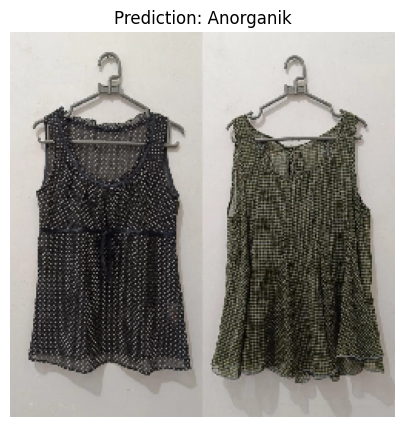

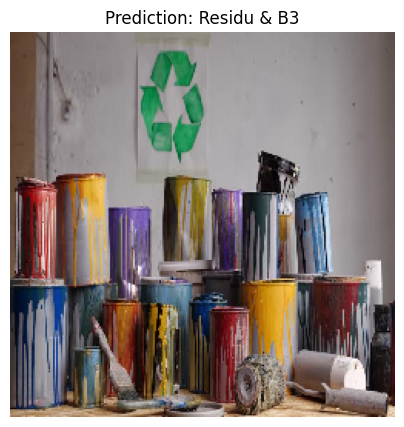

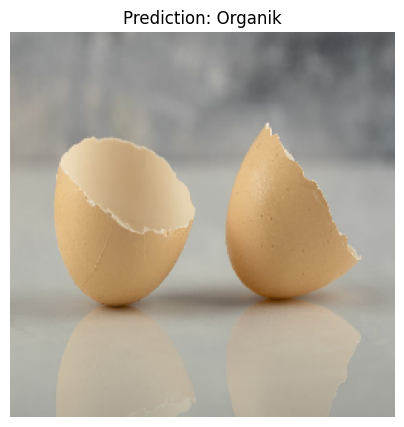

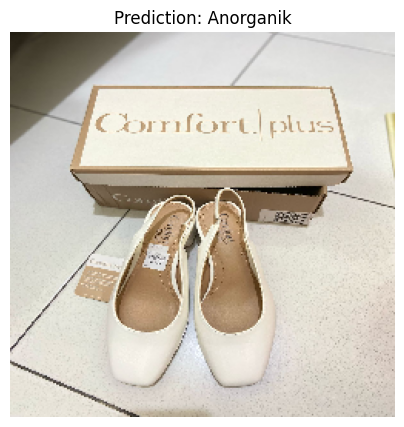

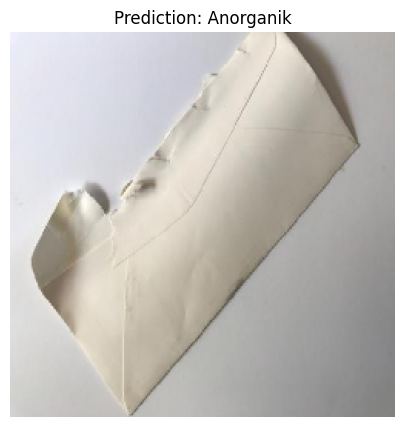

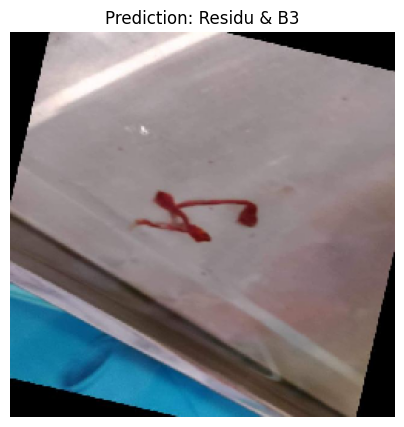

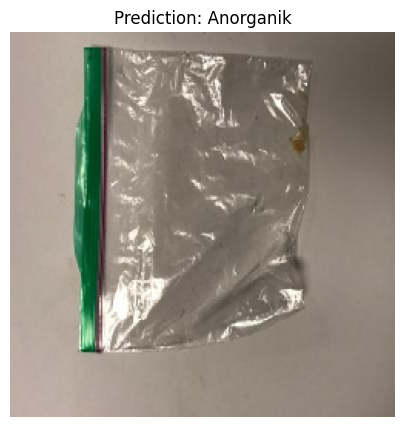

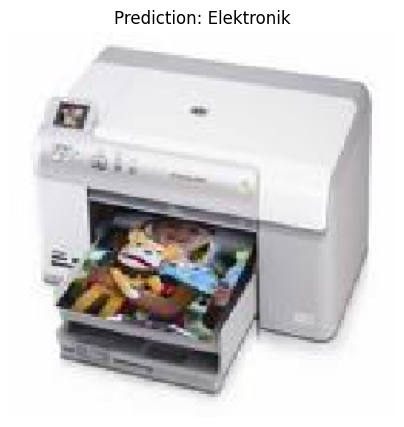

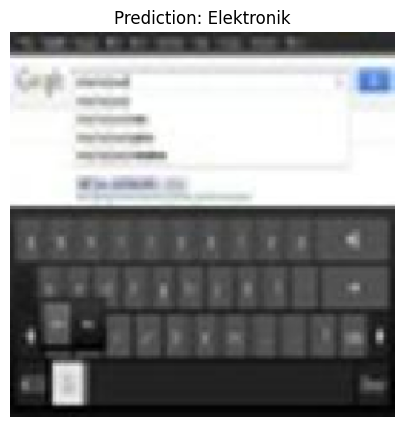

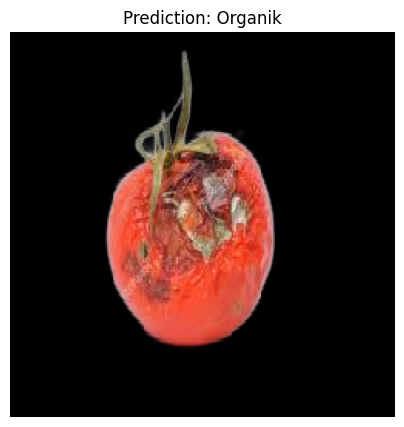

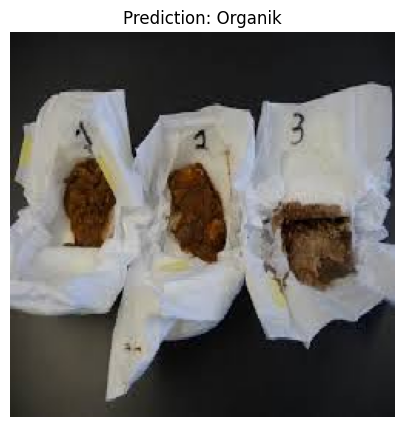

In [ ]:
from tensorflow.keras.preprocessing import image
# Mendapatkan path file yang diupload
model_path = '/content/model.tflite'
inference_zip_path = '/content/inference.zip'

# Mengekstrak file ZIP
with zipfile.ZipFile(inference_zip_path, 'r') as zip_ref:
    zip_ref.extractall("/content/inference_images")

# Menyusun input dan memuat model
interpreter = lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

# Menyiapkan fungsi untuk prediksi
def predict_image(image_path):
    img = image.load_img(image_path, target_size=TARGET_SIZE)  # Ukuran gambar diubah ke (250, 250)
    img_array = image.img_to_array(img) / 255.0  # Normalisasi gambar jika perlu
    img_array = np.expand_dims(img_array, axis=0)  # Membuat batch

    interpreter.set_tensor(interpreter.get_input_details()[0]['index'], img_array)
    interpreter.invoke()

    output_details = interpreter.get_output_details()
    output = interpreter.get_tensor(output_details[0]['index'])

    return output

# Kelas yang sesuai dengan model Anda
class_labels = labels

# Menjalankan prediksi untuk semua gambar dalam folder 'inference'
predictions = {}

inference_folder = "/content/inference_images/inference"  # Folder yang berisi gambar

for img_name in os.listdir(inference_folder):
    img_path = os.path.join(inference_folder, img_name)

    # Hanya proses jika ini adalah file gambar
    if os.path.isfile(img_path):
        pred = predict_image(img_path)

        # Menentukan kelas dengan probabilitas tertinggi
        predicted_class_index = np.argmax(pred)  # Mendapatkan index kelas dengan nilai tertinggi
        predicted_class_label = class_labels[predicted_class_index]

        predictions[img_name] = predicted_class_label

        # Menampilkan gambar dan label prediksi
        img = image.load_img(img_path, target_size=TARGET_SIZE)
        plt.figure(figsize=(5,5))
        plt.imshow(img)
        plt.title(f"Prediction: {predicted_class_label}")
        plt.axis('off')  # Menghilangkan axis
        plt.show()

## **Download All**

In [ ]:
from google.colab import files

# Path ke folder submission yang ingin didownload
submission_dir = '/content/sample_data/path_utama/submission/'

# Membuat folder submission jika belum ada
if not os.path.exists(submission_dir):
    os.makedirs(submission_dir)

# Membuat file zip yang berisi model dan file terkait
submission_zip = '/content/sample_data/path_utama/submission.zip'

with zipfile.ZipFile(submission_zip, 'w') as zipf:
    # Menambahkan folder tfjs_model ke zip
    tfjs_model_dir = '/content/sample_data/path_utama/modeltfjs/'
    for foldername, subfolders, filenames in os.walk(tfjs_model_dir):
        for filename in filenames:
            zipf.write(os.path.join(foldername, filename),
                       os.path.relpath(os.path.join(foldername, filename),
                                      tfjs_model_dir))

    # Menambahkan folder tflite ke zip
    tflite_dir = '/content/sample_data/path_utama/tflite/'
    for foldername, subfolders, filenames in os.walk(tflite_dir):
        for filename in filenames:
            zipf.write(os.path.join(foldername, filename),
                       os.path.relpath(os.path.join(foldername, filename),
                                      tflite_dir))

    # Menambahkan folder saved_model ke zip
    saved_model_dir = '/content/sample_data/path_utama/saved_model/'
    for foldername, subfolders, filenames in os.walk(saved_model_dir):
        for filename in filenames:
            zipf.write(os.path.join(foldername, filename),
                       os.path.relpath(os.path.join(foldername, filename),
                                      saved_model_dir))

# Mengunduh file ZIP
files.download(submission_zip)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Membuat file requirements.txt dengan semua paket yang terinstal
!pip freeze > requirements.txt

# Mengunduh file requirements.txt ke komputer/laptop Anda
files.download('requirements.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>